In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
#experiment = Experiment(api_key="XEglZlWHI72CqIq1hcr3RSw7j", project_name="GAN-BN-D", workspace="kraing")

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Dataset
import keras.datasets as ds

# Unconditional GAN
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, UpSampling2D

# Conditional GAN
from keras.models import Model
from keras.layers import Input, Embedding, Concatenate

# Visualization tools
from IPython.display import clear_output, Image
import time

Using TensorFlow backend.


In [2]:
# Load selected dataset and make some preprocessing
def load_dataset(dataset):

    if dataset == 'MNIST':
        (trainX, trainy), (_, _) = ds.mnist.load_data()

    if dataset == 'Fashion-MNIST':
        (trainX, trainy), (_, _) = ds.fashion_mnist.load_data()

    # Exapnd to 3D adding one channel
    X = np.expand_dims(trainX, axis=-1)

    # Convert from int to float and rescale from [0, 255] to [-1, 1]
    X = X.astype('float32')
    X = (X - (255 / 2)) / (255 / 2)
    #X = X / 255.
    return [X, trainy]



# Build Discriminator
def build_discriminator(input_shape):

    # Initialize the NN
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(128, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Second convolutional layer
    model.add(Conv2D(256, 3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Flattening and output layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



# Build Generator with default latent_space=100
def build_generator(latent_dim=100):

    # Initialize the NN
    model = Sequential()

    # Fully connected layer
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Dropout(0.4))

    # First upsampling layer 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second upsampling layer 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer
    model.add(Conv2D(1, 3, activation='tanh', padding='same'))
    return model



# Build the GAN framework
def build_gan(D, G, input_shape, latent_dim):

    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False

    # Connect generator and discriminator
    GAN = Sequential()
    GAN.add(G)
    GAN.add(D)
    GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return GAN

In [ ]:
def gen_real(dataset, batch_size):
    X = dataset[np.random.randint(0, dataset.shape[0], size=batch_size), :, :, :]
    y = np.ones((batch_size, 1))
    return X, y


def gen_fake(G, latent_dim, batch_size):
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    X = G.predict(z)
    y = np.zeros((batch_size, 1))
    return X, y


def save_plot(G, noise, epoch):
    # Plot generator prediction on sample_noise
    images = G.predict(noise)
    plt.figure(figsize=(10,10))
        
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output/MNIST-D/{epoch}.png')
    plt.close('all')
    
    
def save_model(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model/{name}/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model/{name}/D_{epoch + 1}.h5'
    G.save(filename)

    
# Train the GAN
def train(D, G, GAN, dataset, name, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    sample_noise = np.random.randn(latent_dim * 16).reshape(16, latent_dim)
    
    D_loss = []
    D_acc_r = []
    D_acc_f = []
    
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        # Save generated samples and NN models
        save_plot(G, sample_noise, epoch)
        save_model(epoch, G, D, name)
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc_r = []
        eD_acc_f = []
        
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            realX, realY = gen_real(dataset, half_batch)
            
            # Random generate half_batch fake samples
            fakeX, fakeY = gen_fake(G, latent_dim, half_batch)
            
            '''
            # Stacks all samples together and train the discriminator ---> should be faster
            #X, y = np.vstack((realX, fakeX)), np.vstack((realY, fakeY))
            #D_stats = D.train_on_batch(X, y)
            '''
            
            # Train the discriminator on the real batch, and generated batch
            D_stats_real = D.train_on_batch(realX, realY)
            D_stats_fake = D.train_on_batch(fakeX, fakeY)
            
            # Generate random noise and labels to train the Generator
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch(Z_gan, y_gan)
            
            # Save batch parameters
            eD_loss.append(0.5 * (D_stats_real[0] + D_stats_fake[0]))
            eD_acc_r.append(D_stats_real[1])
            eD_acc_f.append(D_stats_fake[1])
                           
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])
            
            # Log comet metrics
            experiment.log_metrics({"loss_d":0.5 * (D_stats_real[0] + D_stats_fake[0]), "loss_g":G_stats[0], "acc_d_real":D_stats_real[1], "acc_d_fake":D_stats_fake[1], "acc_g":G_stats[1]}, step=(batch_per_epoch * epoch + mbatch))
        
        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc_r.append(eD_acc_r)
        D_acc_f.append(eD_acc_f)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f   da_r=%.3f da_f=%.3f   ga=%.3f   time=%.3f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc_r), np.mean(eD_acc_f), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc_r, D_acc_f, G_loss, G_acc

In [ ]:
# Load dataset
trainX, trainy = load_dataset('MNIST')

# Define latent space>
latent_space = 100
in_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

# Build Generator and Discriminator
D = build_discriminator(input_shape=in_shape)
G = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN = build_gan(D, G, in_shape, latent_space)


In [ ]:
# Train DCGAN
D_l, D_a_r, D_a_f, G_l, G_a = train(D, G, GAN, trainX, name='MNIST-D', latent_dim=latent_space)

In [ ]:
# Show some generated images
tmp_noise = np.random.randn(16 * latent_space).reshape(16,latent_space)

images = G.predict(tmp_noise)

plt.figure(figsize=(10,10))

for im in range(images.shape[0]):
    plt.subplot(4, 4, im+1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])
            
    plt.imshow(image, cmap='gray')
    plt.axis('off')
        
plt.tight_layout()
plt.show()
#plt.savefig(f'output/mnist-d/{epoch}.png')
plt.close('all')


In [ ]:
'''
# Test on fashion-mist
# Load dataset
fashion_mnist, _ = load_dataset('Fashion-MNIST')

# Plot dataset element
plt.figure()
img = np.reshape(fashion_mnist[1], [28, 28])
plt.imshow(img, cmap='gray')
plt.show()

# Define latent space
latent_space = 100
in_shape = (fashion_mnist[0].shape[0], fashion_mnist[0].shape[1], 1)

print('Shape:', in_shape)

# Build Generator and Discriminator
D_f = build_discriminator(input_shape=in_shape)
G_f = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN_f = build_gan(D_f, G_f, in_shape, latent_space)

# Train DCGAN
Df_l, Df_a_r, Df_a_f, Gf_l, Gf_a = train(D_f, G_f, GAN_f, fashion_mnist, latent_dim=latent_space)
'''

In [ ]:
test = []

for i in range(10):
    tmp_z = np.random.randn(latent_space).reshape(1,latent_space)

    gen = G_f.predict(tmp_z)
    test.append(D_f.predict(gen))
    print(test[i])
    plt.figure()
    img = np.reshape(gen, [28, 28])
    plt.imshow(img, cmap='gray')
    plt.show()
    


In [ ]:
D_l = np.reshape(D_l, [len(D_l) * len(D_l[0])])
print(len(D_l))

plt.figure()
plt.plot(D_l)
plt.show()

In [ ]:
G_l = np.reshape(G_l, [len(G_l) * len(G_l[0])])
plt.figure()
plt.plot(G_l)
plt.show()


In [ ]:
#y = np.ones((60000, 1))
training_acc = D.predict(trainX)

plt.figure()
plt.plot(training_acc)
plt.show()

In [ ]:
print(training_acc.shape)

In [ ]:
real = 0
fake = 0

for i in range(training_acc.shape[0]):
    if training_acc[i] >= 0.5:
        real += 1
    else:
        fake += 1

print('Training Accuracy: ', real/training_acc.shape[0])

In [ ]:
# Random generate half_batch fake samples
fakeX, fakeY = gen_fake(G, latent_space, training_acc.shape[0])

gen_acc = D.predict(fakeX)

plt.figure()
plt.plot(gen_acc, '.')
plt.show()

real = 0
fake = 0

for i in range(training_acc.shape[0]):
    if gen_acc[i] >= 0.5:
        real += 1
    else:
        fake += 1

print('Generated Accuracy: ', real/training_acc.shape[0])

In [ ]:

# at the end of your training, end the Comet experiment
experiment.end()

## CDCGAN
In order to build a conditional gan we need to use also the label informatioh from the dataset and concatenate it with the training data.<br>
Following ... advices we embedded the label info in a new channel to the NN. To do this we used Keras Functional API instead of Sequential Model because this last one does not allow multiple inputs to the network.

In [3]:
# Build conditional-dcgan discriminator
def build_CD(input_shape, classes):
    
    # Define input label
    input_label = Input(shape=(1,))
    
    # One-hot-encode label on larger vector
    label_layer = Embedding(classes, 64)(input_label)
    
    # Connect one-hot-encoded layer to a fully connected one of shape of the input image and reshape
    label_layer = Dense(input_shape[0] * input_shape[1])(label_layer)
    label_layer = Reshape((input_shape[0], input_shape[1], 1))(label_layer)
    
    # Define layer for input image data
    image_layer = Input(shape=input_shape)
    
    # Concatenate image-data with label-data
    merged_layer = Concatenate()([image_layer, label_layer])
    
    # First Conv Layer
    layer = Conv2D(128, 3, strides=2, padding='same')(merged_layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Second Conv Layer
    layer = Conv2D(128, 3, strides=2, padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Flatten and output
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    
    D = Model([image_layer, input_label], output_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return D


# Build conditional-dcgan generator
def build_CG(latent_dim, classes):
    
    # Define input label
    input_label = Input(shape=(1,))
    
    # One-hot-encode on larger vector
    label_layer  = Embedding(classes, 64)(input_label)
    
    # Connect one-hot-encoded layer to a 
    label_layer = Dense(7 * 7)(label_layer)
    label_layer = Reshape((7, 7, 1))(label_layer)
    
    
    # Define noise layer 
    input_noise = Input(shape=(latent_dim,))
    noise_layer = Dense(7 * 7 * 256)(input_noise)
    noise_layer = LeakyReLU(alpha=0.2)(noise_layer)
    noise_layer = Reshape((7, 7, 256))(noise_layer)
    
    # Concatenate noise layer with label layer
    merged_layer = Concatenate()([noise_layer, label_layer])
    
    # First Upsample Layer
    layer = UpSampling2D()(merged_layer)
    layer = Conv2D(256, 3, padding='same')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Second Upsample Layer
    layer = UpSampling2D()(layer)
    layer = Conv2D(128, 3, padding='same')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Output Layer
    output_layer = Conv2D(1, 3, activation='tanh', padding='same')(layer)
    
    G = Model([input_noise, input_label], output_layer)
    return G



# Build conditional-dcgan framework
def build_CDCGAN(D, G):
    
    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False
    
    # Define generator in/out
    G_noise, G_label = G.input
    G_output = G.output
    
    print(G_output.shape, G_label.shape)
    
    # Connect G to D
    GAN_output = D([G_output, G_label])
    
    
    # Define and compile GAN model
    CDCGAN = Model([G_noise, G_label], GAN_output)
    CDCGAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return CDCGAN
    

In [4]:
def gen_real_c(dataset, batch_size):
    img, label = dataset
    
    random_index = np.random.randint(0, img.shape[0], size=batch_size)
    X, label = img[random_index], label[random_index]
    y = np.ones((batch_size, 1))
    return [X, label], y


def gen_fake_c(G, latent_dim, batch_size, classes):
    
    # Generate random noise + label
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    label = np.random.randint(0, classes, batch_size)
    
    # Predict image from noise
    X = G.predict([z, label])
    y = np.zeros((batch_size, 1))
    return [X, label], y


In [8]:
def save_plot_c(G, noise, label, epoch):
    # Plot generator prediction on sample_noise
    images = G.predict([noise, label])
    plt.figure(figsize=(10,10))
        
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output/MNIST-D/{epoch}.png')
    plt.close('all')
    
    
def save_model_c(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model/{name}/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model/{name}/D_{epoch + 1}.h5'
    G.save(filename)
    
    
def train_c(D, G, GAN, dataset, name, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    sample_label = np.random.randint(0, 10, batch_size)
    sample_noise = np.random.randn(latent_dim * 16).reshape(16, latent_dim)
    
    D_loss = []
    D_acc_r = []
    D_acc_f = []
    
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        # Save generated samples and NN models
        save_plot_c(G, sample_noise, sample_label, epoch)
        save_model_c(epoch, G, D, name)
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc_r = []
        eD_acc_f = []
        
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            [realX, real_Label], realY = gen_real_c(dataset, half_batch)
            
            # Random generate half_batch fake samples
            [fakeX, fake_Label], fakeY = gen_fake_c(G, latent_dim, half_batch, classes=10)
            
            # Train the discriminator on the real batch, and generated batch
            D_stats_real = D.train_on_batch([realX, real_Label], realY)
            D_stats_fake = D.train_on_batch([fakeX, fake_Label], fakeY)
            
            # Generate random noise and labels to train the Generator
            label_gan = np.random.randint(0, 10, batch_size)
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch([Z_gan, label_gan], y_gan)
            
            # Save batch parameters
            eD_loss.append(0.5 * (D_stats_real[0] + D_stats_fake[0]))
            eD_acc_r.append(D_stats_real[1])
            eD_acc_f.append(D_stats_fake[1])
                           
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])
            
            # Log comet metrics
            #experiment.log_metrics({"loss_d":0.5 * (D_stats_real[0] + D_stats_fake[0]), "loss_g":G_stats[0], "acc_d_real":D_stats_real[1], "acc_d_fake":D_stats_fake[1], "acc_g":G_stats[1]}, step=(batch_per_epoch * epoch + mbatch))
        
        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc_r.append(eD_acc_r)
        D_acc_f.append(eD_acc_f)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f   da_r=%.3f da_f=%.3f   ga=%.3f   time=%.3f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc_r), np.mean(eD_acc_f), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc_r, D_acc_f, G_loss, G_acc

In [9]:
# Load dataset
dataset = load_dataset('MNIST')

# Define latent space>
latent_space = 100
in_shape = (dataset[0].shape[1], dataset[0].shape[2], 1)
print(in_shape)
classes  = 10

# Build Generator and Discriminator
CD = build_CD(input_shape=in_shape, classes=classes)
CG = build_CG(latent_dim=latent_space, classes=classes)

# Create DCGAN framework
CGAN = build_CDCGAN(CD, CG)

(28, 28, 1)
(None, 28, 28, 1) (None, 1)


In [10]:
# Train CDCGAN
cD_l, cD_a_r, cD_a_f, cG_l, cG_a = train_c(CD, CG, CGAN, dataset, name='MNIST-D', latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\li

Epoch- 0: dl=0.692 gl=0.668   da_r=0.638 da_f=0.341   ga=0.517   time=49.951
Epoch- 1: dl=0.691 gl=0.694   da_r=0.660 da_f=0.399   ga=0.478   time=47.219
Epoch- 2: dl=0.690 gl=0.702   da_r=0.611 da_f=0.474   ga=0.420   time=45.664
Epoch- 3: dl=0.690 gl=0.704   da_r=0.568 da_f=0.493   ga=0.414   time=45.870
Epoch- 4: dl=0.690 gl=0.705   da_r=0.575 da_f=0.500   ga=0.409   time=46.343
Epoch- 5: dl=0.690 gl=0.707   da_r=0.554 da_f=0.525   ga=0.398   time=46.066
Epoch- 6: dl=0.689 gl=0.708   da_r=0.553 da_f=0.522   ga=0.393   time=46.375
Epoch- 7: dl=0.690 gl=0.709   da_r=0.558 da_f=0.523   ga=0.404   time=52.967
Epoch- 8: dl=0.688 gl=0.710   da_r=0.576 da_f=0.514   ga=0.418   time=50.202
Epoch- 9: dl=0.691 gl=0.708   da_r=0.546 da_f=0.507   ga=0.415   time=57.313
Epoch-10: dl=0.691 gl=0.710   da_r=0.541 da_f=0.517   ga=0.405   time=53.405
Epoch-11: dl=0.691 gl=0.709   da_r=0.549 da_f=0.506   ga=0.417   time=49.521
Epoch-12: dl=0.691 gl=0.709   da_r=0.542 da_f=0.519   ga=0.410   time=48.111

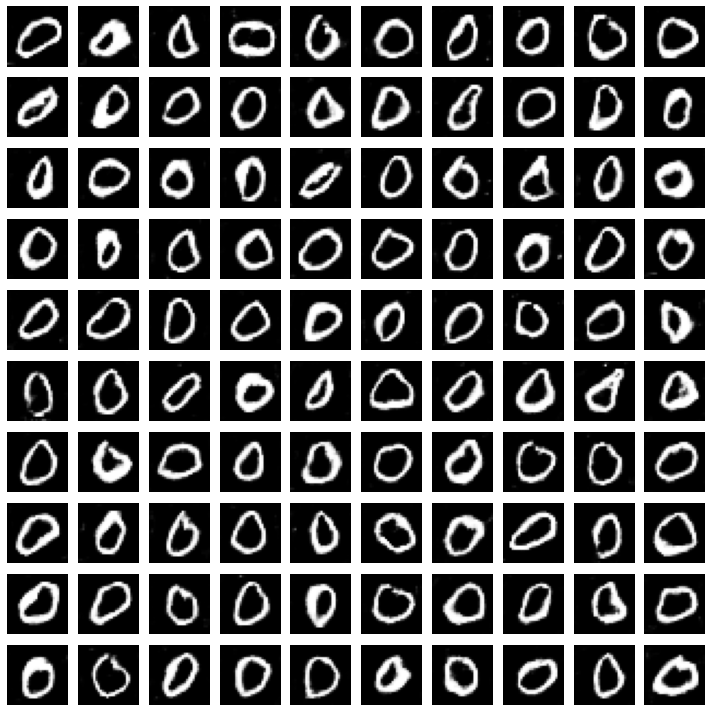

In [23]:
custom_label = []

# SAMPLE NUMBER MUST BE A PERFECT-SQUARE
sample_number = 100

for i in range(sample_number):
    custom_label.append(0)
    
custom_label = np.asarray(custom_label)

# Show some generated images
tmp_noise = np.random.randn(sample_number * latent_space).reshape(sample_number, latent_space)

images = CG.predict([tmp_noise, custom_label])

plt.figure(figsize=(10,10))

for im in range(images.shape[0]):
    plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])
            
    plt.imshow(image, cmap='gray')
    plt.axis('off')
        
plt.tight_layout()
plt.show()
plt.close('all')
